In [1]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res

In [2]:
import sys; sys.path.append('../')

import json
import pathlib
import typing as tp

import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import models

from dataset import ImageClassifyDataset
from net_factory import NeuralNetwork


CLASSES_NUM = 50


data_dir = pathlib.Path("/home/david/study/shad/cv_fall_2022/lesson_7_transfer_learning/data/00_test_img_input")
output_dir = ""

train_dir = data_dir/'train'
test_dir = data_dir/'test'

train_gt: tp.Dict[str, np.ndarray] = read_csv(train_dir/'gt.csv')
train_img_dir = train_dir/'images'

test_img_dir = test_dir/'images'

# model = train_classifier(train_gt, train_img_dir, fast_train=False)

# model_filename = './facepoints_model.ckpt'
# test_img_dir = test_dir/'images'
# img_classes = classify(model_filename, test_img_dir)
# # save_csv(detected_points, join(output_dir, 'output.csv'))

In [3]:
ds = ImageClassifyDataset(CLASSES_NUM, "train", 0.932, train_img_dir, train_gt, new_size=(0, 0))
len(ds)

2330

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

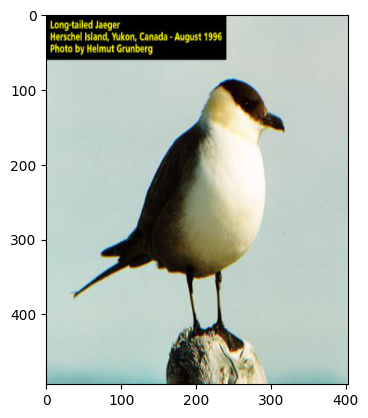

In [4]:
i = 1
plt.imshow(ds[i][0].numpy().transpose(1, 2, 0));
ds[i][1]

In [5]:
# with open('./configs/architectures/simple_cnn.json') as f:
#     net_arch = json.load(f)

In [6]:
with open('./configs/learning_process/base.json') as f:
    learning_process = json.load(f)

In [7]:
dataset_params = learning_process["dataset_params"]
train_fraction = dataset_params["train_fraction"]
if dataset_params["augmentation"] is None:
    transforms = None
else:
    transforms = [
        globals()[dict_["transform_type"]](**dict_["params"])
            for dict_ in dataset_params["augmentation"]
    ]

train_dataset = ImageClassifyDataset(
    classes_num=CLASSES_NUM,
    mode="train",
    train_fraction=train_fraction,
    data_dir=train_img_dir,
    train_gt=train_gt,
    new_size=(256, 256),  # dataset_params["new_size"],
    transforms=transforms
)

val_dataset = ImageClassifyDataset(
    classes_num=CLASSES_NUM,
    mode="val",
    train_fraction=train_fraction,
    data_dir=train_img_dir,
    train_gt=train_gt,
    new_size=(256, 256),  # dataset_params["new_size"]
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size = dataset_params["train_batch_size"],
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size = dataset_params["val_batch_size"],
    shuffle=True
)

In [8]:
class BirdNet(torch.nn.Module):
    def __init__(
            self,
            base_net: torch.nn.Module,
            output_classes_num: int = 50,
            first_layers_number_to_be_frozen: int = 9
    ):
        super().__init__()
        assert first_layers_number_to_be_frozen >= 0,\
            "Variable freeze_first do not supports of negative numbers."
        
        self._base_net = base_net
        in_features_at_last_fc = list(self._base_net.children())[-1].in_features
        self._base_net.fc = torch.nn.Linear(
            in_features = in_features_at_last_fc,
            out_features = output_classes_num
        )
        
        for layer_id, layer in enumerate(self._base_net.children()):
            if layer_id < first_layers_number_to_be_frozen:
                for param in layer.parameters():
                    param.requires_grad = False
        
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._base_net.forward(x)
    
    
#     def predict_proba(self, x: torch.Tensor) -> torch.Tensor:
#         return torch.nn.Softmax(self(x))


In [9]:
loss_params = learning_process["hyper_params"]["loss"]
optimizer_params = learning_process["hyper_params"]["optimizer"]
epoch_nums = learning_process["hyper_params"]["epoch_nums"]

net = BirdNet(
    base_net = models.resnet18(pretrained=True),
    first_layers_number_to_be_frozen = 9
)
loss = getattr(torch.nn, loss_params["loss_type"])(**loss_params["params"])
optimizer = getattr(torch.optim, optimizer_params["optimizer_type"])(
    net.parameters(),
    **optimizer_params["params"]
)
optimizer.zero_grad()

best_val_loss = float("inf")

/home/david/.pyenv/envs/main_py/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/david/.pyenv/envs/main_py/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
!rm -rf ./runs

# default `log_dir` is "runs".
writer = SummaryWriter('./runs')

for epoch in range(epoch_nums - 1):
    print(f"{epoch=}:")

    net.train()
    loss_history = []
    for X, y, _ in train_dataloader:
        optimizer.zero_grad()
        y_pred = net(X)
        loss_value = loss(y_pred, y)
        loss_value.backward()
        optimizer.step()
        cur_train_loss = loss_value.cpu().data.item()
        loss_history.append(cur_train_loss)
        print("train_loss: %.4f" % cur_train_loss, end='\r')

    train_loss = np.mean(loss_history)
    print("train_loss:\t%.5f" % train_loss)

    net.eval()
    loss_history = []
    eq_history = []
    with torch.no_grad():
        for X, y, shape in val_dataloader:
            shape = shape.numpy()
            y_pred = net(X)
            eq_history.extend(
                list(y_pred.cpu().data.numpy().argmax(axis=1) == y.data.cpu().numpy().argmax(axis=1))
            )
            loss_value = loss(y_pred, y)
            loss_history.append(loss_value.cpu().data.item())

    val_loss = np.mean(loss_history)
    print("val_loss:\t%.5f" % val_loss)
    print("val_accuray:\t%.5f" % np.mean(eq_history))
    
    writer.add_scalars(
        'Loss',
        {
            'train': train_loss,
            'val': val_loss
        },
        epoch
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            },
            pathlib.Path("./facepoints_model.ckpt")
        )
        print("*")
    print()

writer.close()

epoch=0:
train_loss:	3.91564
val_loss:	3.79496
val_accuray:	0.05200
*

epoch=1:
train_loss:	3.56746
val_loss:	3.46253
val_accuray:	0.17200
*

epoch=2:
train_loss:	3.29004
val_loss:	3.22457
val_accuray:	0.27600
*

epoch=3:
train_loss:	3.04062
val_loss:	3.01489
val_accuray:	0.38400
*

epoch=4:
train_loss:	2.81788
val_loss:	2.78486
val_accuray:	0.46800
*

epoch=5:
train_loss:	2.61125
val_loss:	2.64990
val_accuray:	0.48800
*

epoch=6:
train_loss:	2.43251
val_loss:	2.46581
val_accuray:	0.53600
*

epoch=7:
train_loss:	2.27000
val_loss:	2.34804
val_accuray:	0.56800
*

epoch=8:
train_loss:	2.12779
val_loss:	2.22482
val_accuray:	0.57200
*

epoch=9:
train_loss:	1.99927
val_loss:	2.12033
val_accuray:	0.61200
*

epoch=10:
train_loss:	1.88360
val_loss:	2.00326
val_accuray:	0.61600
*

epoch=11:
train_loss:	1.78072
val_loss:	1.92440
val_accuray:	0.64400
*

epoch=12:
train_loss:	1.67920
val_loss:	1.86365
val_accuray:	0.63600
*

epoch=13:
train_loss:	1.60068
val_loss:	1.75039
val_accuray:	0.66800
*

ep

KeyboardInterrupt: 